<center><h1><b>Proyecto de Curso Aprendizaje Automático</b></h1>
<h2><b>Escuela de Posgrado PUCP</b></h2>
<h2><b>Maestría en Informática</b></h2></center>

**<h2>Importación de Librerías</h2>**


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn import preprocessing
from sklearn import naive_bayes
from sklearn import svm
from sklearn import pipeline
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer

import numpy as np
matplotlib.rcParams['figure.dpi'] = 100

**<h2>Lectura de la data</h2>**

El conjunto de datos consta de los niveles de expresión de 77 proteínas que produjeron señales detectables en la parte nuclear del córtex (características continuas). Se tienen 38 ratones  sanos  y  34  ratones trisómicos  organizados en ocho clases (cada uno conformado por entre  7  y  10  ratones).  Por cada ratón se  han  tomado 15  muestras, por  ende, se tendrán 570 y  510 muestras para los ratones sanos y trisómicos respectivamente.

In [2]:
dataset = pd.read_excel("Data_Cortex_Nuclear.xls")

In [3]:
print(f"Las dimensiones del dataset son {dataset.shape}")
dataset.head()

Las dimensiones del dataset son (1080, 82)


,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


**<h2>Preprocesamiento</h2>**

La estrategia que se utilizará para el manejo de datos faltantes será la imputación de los mismos por el estadístico media para cada clase.

**<h3>Eliminación de Características innecesarias y codificación de la clase</h3>**

In [4]:
preprocDataset = dataset.copy()

#Se elimina información redundante "Genotype", "Treatment", "Behavior" que ya están combinadas en la columna clase.
preprocDataset.drop(["Genotype", "Treatment", "Behavior"], axis=1, inplace=True)

#Se separan las versiones y números de ratones en otras variables
MouseNumber = preprocDataset.MouseID.apply(lambda x: x.split('_')[0])
MouseVersion = preprocDataset.MouseID.apply(lambda x: x.split('_')[1])

#Se elimina información irrelevante para la tarea de clasificación multiclase
preprocDataset.drop("MouseID", axis=1, inplace=True)

from sklearn.preprocessing import LabelEncoder

preprocDataset["class"] = LabelEncoder().fit_transform(preprocDataset["class"])

**<h3>Imputación de datos faltantes</h3>**

Dado que se aplicará validación K-Fold durante la búsqueda y optimización de cada hiperparámetro, se realizará la imputación de datos faltantes durante cada iteración de validación, mediante el uso de un imputador que usa la mediana de cada característica, dicho imputador será agregado al inicio del pipeline de entrenamiento.

**<h2> Separación y etiquetado de datos</h2>**

In [5]:
x = preprocDataset.drop("class",axis=1)
y = preprocDataset["class"]

**<h3>Análisis de separabilidad de la data</h3>**

In [6]:
#Imputacion temporal del dataset para realizar el gráfico T-SNE.
x_imputed = SimpleImputer(strategy="mean").fit_transform(x)
x_embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(x_imputed)

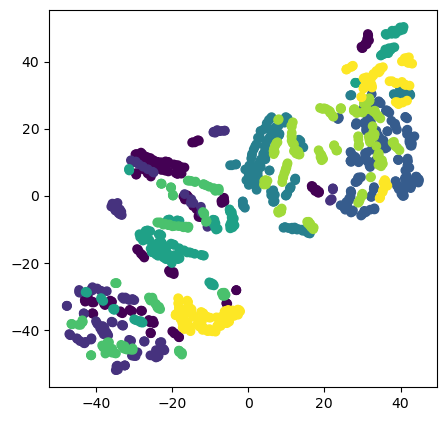

In [7]:
plt.figure(figsize=(5, 5))
plt.scatter(x_embedded[:,0], x_embedded[:,1], c=y)
plt.show()

Se observa del gráfico t-SNE que las clases de los datos están medianamente separados, por tanto, se espera que los modelos a entrenar tengan una precisión razonablemente alta.

**<h2>Separación de conjunto de entrenamiento de conjunto de pruebas</h2>**

In [8]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, train_size=0.8,random_state=0,stratify=y)
print(f"El tamaño del conjunto de prueba es: {x_train.shape}.")
print(f"El tamaño del conjunto de prueba es: {x_test.shape}.")

El tamaño del conjunto de prueba es: (864, 77).
El tamaño del conjunto de prueba es: (216, 77).


## Escalamiento de data

Se utilizará la clase ***pipeline*** para realizar el escalamiento sólo en la data de entrenamiento correspondiente a la validación ***k-fold***, por lo que el escalamiento se realizará previo al entrenamiento de cada modelo.

# Algoritmos a entrenar

## Random Forest

In [9]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
rfc_imputer = SimpleImputer(strategy='mean')
rfc_scaler = preprocessing.StandardScaler()
rfc_model = RandomForestClassifier(class_weight="balanced",random_state=0)
rfc_pipeline = pipeline.Pipeline([("imputer", rfc_imputer),("scaler", rfc_scaler), ("rfc", rfc_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
grid_rfc = {"rfc__n_estimators": range(1,400,10), 
            "rfc__max_depth": range(1,31,3),
            "rfc__min_samples_split": range(2, 40, 1),
            "rfc__min_samples_leaf": range(1, 20, 1)}

In [10]:
#Busqueda aleatoria
r_search_rfc =model_selection.RandomizedSearchCV(rfc_pipeline, grid_rfc, n_iter=40, n_jobs=-1,cv=8, random_state=0)
r_search_rfc.fit(x_train, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('rfc',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=0))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'rfc__max_depth': range(1, 31, 3),
                                        'rfc__min_samples_leaf': range(1, 20),
                                        'rfc__min_samples_split': range(2, 40),
                                        'rfc__n_estimators': range(1, 400, 10)},
                   random_state=0)

In [11]:
best_rfc_pipeline = r_search_rfc.best_estimator_

train_score = best_rfc_pipeline.score(x_train, y_train)
test_score = best_rfc_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo RF es: {train_score}.")
print(f"La exactitud de prueba para el modelo RF es: {test_score}.")

La exactitud de entrenamiento para el modelo RF es: 1.0.
La exactitud de prueba para el modelo RF es: 0.9953703703703703.


## Support Vector Machine

In [12]:
#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
svm_imputer = SimpleImputer(strategy='mean')
svm_scaler = preprocessing.StandardScaler()
svm_model = svm.SVC(kernel="rbf",class_weight="balanced",random_state=0)
svm_pipeline = pipeline.Pipeline([("imputer",svm_imputer), ("scaler", svm_scaler), ("model", svm_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
gamma = np.logspace(-4, 2, num=20)
C = np.logspace(-4, 2, num=20)

grid_svm = {"model__gamma":gamma, "model__C":C}

In [13]:
#Busqueda aleatoria
r_search =model_selection.RandomizedSearchCV(svm_pipeline, grid_svm, n_iter=40,n_jobs=-1,cv=8, random_state=0)
r_search.fit(x_train, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              SVC(class_weight='balanced',
                                                  random_state=0))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'model__C': array([1.00000000e-04, 2.06913808e-04, 4.28133240e-04, 8.85866790e-04,
       1.83298071e-03, 3.79269019e-03, 7.84759970e-03, 1.62377674e-02,
       3.3598182...
       1.12883789e+01, 2.33572147e+01, 4.83293024e+01, 1.00000000e+02]),
                                        'model__gamma': array([1.00000000e-04, 2.06913808e-04, 4.28133240e-04, 8.85866790e-04,
       1.83298071e-03, 3.79269019e-03, 7.84759970e-03, 1.62377674e-02,
       3.35981829e-02, 6.95192796e-02, 1.43844989e-01, 2.97635144e-01,
       6.15848211e-01, 1.274

In [14]:
best_svm_pipeline = r_search.best_estimator_

#Chequear si el scaler se devuelve ajustado con la data de entrenamiento y si no se vuelve a ajustar cuando se le llama
#a score del pipeline
train_score = best_svm_pipeline.score(x_train, y_train)
test_score = best_svm_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo SVM con kernel RBF es: {train_score}.")
print(f"La exactitud de prueba para el modelo SVM con kernel RBF es: {test_score}.")

La exactitud de entrenamiento para el modelo SVM con kernel RBF es: 1.0.
La exactitud de prueba para el modelo SVM con kernel RBF es: 0.9907407407407407.


## Redes neuronales

## Regresión Logística

In [15]:
from sklearn.linear_model import LogisticRegression

#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
lr_imputer = SimpleImputer(strategy='mean')
lr_scaler = preprocessing.StandardScaler()
lr_model = LogisticRegression(penalty="l2", class_weight="balanced", solver="lbfgs", random_state=47, max_iter=200)
lr_pipeline = pipeline.Pipeline([("imputer", lr_imputer), ("scaler", lr_scaler), ("model", lr_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
C = np.logspace(-4, 4, num=401)

grid_lr = {"model__C":C}

In [16]:
#Busqueda aleatoria
r_search = model_selection.RandomizedSearchCV(lr_pipeline, grid_lr, n_iter=40, n_jobs=-1, cv=8, random_state=47)
r_search.fit(x_train, y_train)

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=200,
                                                                 random_state=47))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'model__C': array([1.00000000e-04, 1.04712855e-04, 1.09647820e-04, 1.14815362e-04,
       1.20226443e-04, 1.25892541e-04, 1.31825674...
       3.31131121e+03, 3.46736850e+03, 3.63078055e+03, 3.80189396e+03,
       3.98107171e+03, 4.16869383e+03, 4.36515832e+03, 4.57088190e+03,
       4.78630092e+03, 5.01187234e+03, 5.24807460e+03, 5.49540874e+03,
       5.75439937e+03, 6.02559586e+03, 6.30957344e+03, 6.60693448e+03,
       6.91830

In [17]:
best_lr_pipeline = r_search.best_estimator_

#Chequear si el scaler se devuelve ajustado con la data de entrenamiento y si no se vuelve a ajustar cuando se le llama
#a score del pipeline
train_score = best_lr_pipeline.score(x_train, y_train)
test_score = best_lr_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo Regresión Logística: {train_score}.")
print(f"La exactitud de prueba para el Regresión Logística es: {test_score}.")

La exactitud de entrenamiento para el modelo Regresión Logística: 1.0.
La exactitud de prueba para el Regresión Logística es: 0.9861111111111112.


### Eliminación hacia atrás

In [111]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
imsc_imputer = lr_imputer
imsc_scaler = lr_scaler
imsc_pipeline = pipeline.Pipeline([("imputer", imsc_imputer), ("scaler", imsc_scaler)])

x_train_imsc = imsc_pipeline.transform(x_train)

best_model = best_lr_pipeline["model"]

rfecv = RFECV(estimator=best_model, step=1, cv=StratifiedKFold(8), scoring='accuracy', njobs=-1)
rfecv.fit(x_train_imsc, y_train)

x_train_opt = rfecv.transform(x_train_imsc)

print("Número óptimo de características : %d" % x_train_opt.shape[1])

c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\hector\documents\inf648\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

Número óptimo de características : 69


In [112]:
best_model.fit(x_train_opt, y_train)

x_test_imsc = imsc_pipeline.transform(x_test)
x_test_opt = rfecv.transform(x_test_imsc)

#Chequear si el scaler se devuelve ajustado con la data de entrenamiento y si no se vuelve a ajustar cuando se le llama
#a score del pipeline
train_score = best_model.score(x_train_opt, y_train)
test_score = best_model.score(x_test_opt, y_test)

print(f"La exactitud de entrenamiento para el modelo Regresión Logística: {train_score}.")
print(f"La exactitud de prueba para el modelo Regresión Logística es: {test_score}.")

La exactitud de entrenamiento para el modelo Regresión Logística: 1.0.
La exactitud de prueba para el modelo Regresión Logística es: 0.9814814814814815.


## LightGBM

In [114]:
from lightgbm import LGBMClassifier

#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
lgbm_imputer = SimpleImputer(strategy='mean')
lgbm_scaler = preprocessing.StandardScaler()
lgbm_model = LGBMClassifier()
lgbm_pipeline = pipeline.Pipeline([("imputer", lgbm_imputer), ("scaler", lgbm_scaler), ("lgbm", lgbm_model)])

#Definicion del grid donde se hará la búsqueda de hiperparámetros
grid_lgbm = {"lgbm__max_bin": np.power(2, range(7,10,3)), 
             "lgbm__learning_rate": [2.5e-3,5-3,7.5e-3,1e-2],
             "lgbm__num_leaves": range(250, 500, 25),
             "lgbm__num_iterations": [500]}

In [115]:
lgbm_search = model_selection.RandomizedSearchCV(lgbm_pipeline, grid_lgbm, n_iter=20, n_jobs=-1, cv=8, random_state=47)
lgbm_search.fit(x_train, y_train)

c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('lgbm', LGBMClassifier())]),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'lgbm__learning_rate': [0.0025, 2,
                                                                0.0075, 0.01],
                                        'lgbm__max_bin': array([128], dtype=int32),
                                        'lgbm__num_iterations': [500],
                                        'lgbm__num_leaves': range(250, 500, 25)},
                   random_state=47)

In [116]:
best_lgbm_pipeline = lgbm_search.best_estimator_

#Chequear si el scaler se devuelve ajustado con la data de entrenamiento y si no se vuelve a ajustar cuando se le llama
#a score del pipeline
train_score = best_lgbm_pipeline.score(x_train, y_train)
test_score = best_lgbm_pipeline.score(x_test, y_test)

print(f"La exactitud de entrenamiento para el modelo LightGBM: {train_score}.")
print(f"La exactitud de prueba para el modelo LightGBM: {test_score}.")

La exactitud de entrenamiento para el modelo LightGBM: 1.0.
La exactitud de prueba para el modelo LightGBM: 0.9537037037037037.


### Eliminación hacia atrás

In [120]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

#Definicion de imputación, escalamiento, modelo y pipeline a utilizar para el entrenamiento
imsc_imputer = lgbm_imputer
imsc_scaler = lgbm_scaler
imsc_pipeline = pipeline.Pipeline([("imputer", imsc_imputer), ("scaler", imsc_scaler)])

imsc_pipeline.fit(x_train)

x_train_imsc = imsc_pipeline.transform(x_train)

best_model = best_lgbm_pipeline["lgbm"]

rfecv = RFECV(estimator=best_model, step=1, cv=StratifiedKFold(8), scoring='accuracy', njobs=-1)
rfecv.fit(x_train_imsc, y_train)

x_train_opt = rfecv.transform(x_train_imsc)

print("Número óptimo de características : %d" % x_train_opt.shape[1])

c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\

c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\

c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\

c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\

c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\

c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\

c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\

c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\

c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\

c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\

c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\

c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\

c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\

c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\

c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\

c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\

c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\documents\inf648\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
c:\users\hector\

KeyboardInterrupt: 

In [ ]:
best_model.fit(x_train_opt, y_train)

x_test_imsc = imsc_pipeline.transform(x_test)
x_test_opt = rfecv.transform(x_test_imsc)

#Chequear si el scaler se devuelve ajustado con la data de entrenamiento y si no se vuelve a ajustar cuando se le llama
#a score del pipeline
train_score = best_model.score(x_train_opt, y_train)
test_score = best_model.score(x_test_opt, y_test)

print(f"La exactitud de entrenamiento para el modelo Regresión Logística: {train_score}.")
print(f"La exactitud de prueba para el modelo Regresión Logística es: {test_score}.")